MLP - Multi Layer Perceptron

# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

In [2]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.5 MB/s eta 0:00:0000:01


## import

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os
import matplotlib.pyplot as plt

print(f"파이토치 버전:", torch.__version__)

파이토치 버전: 2.0.1+cu118


### device 설정

In [4]:
torch.cuda.is_available(), torch.backends.mps.is_available()

(True, False)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "mps" if torch.backends.mps.is_available() else "cpu"  #mac
device

'cuda'

### 변수 설정

In [6]:
BATCH_SIZE = 256 # 학습/검증할 때 한번에 몇개의 데이터를 가지고 할지 개수.
N_EPOCH = 20     # 전체 Train set을 한번 학습 시키는 것-> 1 epoch.  epoch 수. 크게 잡아준다.
LR = 0.001       # 학습률. (파라미터 업데이트할 때 지정할 학습률. gradient의 어느 정도를 파라미터 업데이트할 때 사용할 것인지 비율.)

DATASET_SAVE_PATH = 'datasets' # 데이셋을 저장할 디렉토리.
MODEL_SAVE_PATH = 'models'     # 학습된 모델을 저장할 디렉토리.

os.makedirs(DATASET_SAVE_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

## MNIST dataset Loading

### Dataset

In [7]:
# ToTensor() -> ndarray, PIL.Image객체 ==> Tensor 변환, 정규화.(0. ~ 1.)

In [8]:
train_set = datasets.MNIST(root=DATASET_SAVE_PATH,   # 데이터셋 저장할 디렉토리.
                           train=True, # trainset(True) | testset(False) 중 어떤 것 받을 것인지.
                           download=True, #root에 데이터셋이 없으면 다운받을지 여부.
                           transform=transforms.ToTensor() # 데이터 전처리 하는 객체
                          )

test_set = datasets.MNIST(root=DATASET_SAVE_PATH, train=False, download=True,
                          transform=transforms.ToTensor())

In [9]:
print(type(train_set))
print(train_set)
print(test_set)

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
len(train_set), len(test_set)

(60000, 10000)

torch.Size([1, 28, 28]) 5


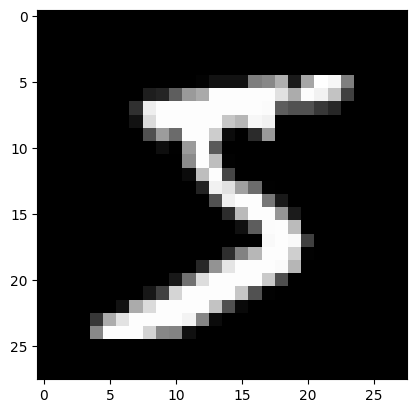

In [11]:
# 트레인셋의 첫번째 데이터 확인.
image, label = train_set[0]
print(image.shape, label)
import matplotlib.pyplot as plt
plt.imshow(image[0], cmap='gray')

### DataLoader

In [12]:
train_loader = DataLoader(train_set, # Dataset 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, # 학습시 1에폭이 끝나면 데이터를 섞어줄지 여부.(기본: False)
                          drop_last=True# 마지막 배치의 개수가 batch_size보다 적으면 버린다.
                         )
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [13]:
print(f"trainset의 1 에폭당 step 수: {len(train_loader)}")
print(f"testset의 1 에폭당 step 수: {len(test_loader)}")
# step: 모델(파라미터) 업데이트 단위.
# 1 에폭당 step수: trainset데이터수 / batch_size

trainset의 1 에폭당 step 수: 234
testset의 1 에폭당 step 수: 40


## 네트워크(모델) 정의
- Network : 전체 모델 구조

In [14]:
# nn.Module을 상속 
class MNISTModel(nn.Module):
    
    def __init__(self):
        """
        모델객체 생성시 모델을 구현할 때 필요한 것들을 초기화.
        필요한것:  Layer들
        """
        super().__init__()   #1. 부모클래스의 __init__()을 호출해서 초기화.
        #2. 필요한 레이어들을 정의.
        self.lr1 = nn.Linear(28*28, 128)    # 피처개수, 노드개수 (1번째 레이어)
        self.lr2 = nn.Linear(128, 64)       #  (2번째 레이어)
        self.lr3 = nn.Linear(64, 10)        #  마지막 레이어. 출력 노드 개수는 분류할 클래스 개수.
        
    def forward(self, X):
        """
        입력을 받아서 최종 출력할 때 까지의 계산 흐름을 구현하는 메소드.
        ===> 순전파(forward propagation)
        파라미터 X: 입력값. - batch
        """
        #3차원인 이미지를 1차원으로 변환. 
        # (데이터개수-batch, channel, height, width) -> (batch, c*h*w)
        X = torch.flatten(X, start_dim=1) # axis 1 이후를 flatten
        X = self.lr1(X)  #WX + b
        X = nn.ReLU()(X) #활성함수(activation function) => 비선형함수.
        
        X = self.lr2(X)
        X = nn.ReLU()(X)
        
        X = self.lr3(X)
        return X

In [15]:
# 정의한 모델클래스로부터 모델객체를 생성
model = MNISTModel()

In [16]:
# 모델의 구조를 확인
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=10, bias=True)
)


In [17]:
# 모델의 구조를 확인하는 라이브러리 -> torchinfo
!pip install torchinfo

In [18]:
from torchinfo import summary
summary(model, (BATCH_SIZE, 784))  # (모델객체, input데이터의 shae) (100: batchsize, 784:feature수)

# self.lr1 = nn.Linear(28*28, 128)
# self.lr2 = nn.Linear(128, 64)
# self.lr3 = nn.Linear(64, 10)

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─Linear: 1-2                            [256, 64]                 8,256
├─Linear: 1-3                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

## train

### 모델, loss function, optimizer 생성

In [19]:
model = model.to(device) # 실제 추론을 담당할 device로 옮긴다. -> 모델, X, y
# loss를 계산하는 함수. 다중분류=>cross entropy
loss_fn = nn.CrossEntropyLoss()  #nn.functional.cross_entropy()
# 모델 추정 결과 -> softmax를 적용해서 확률값으로 변환. -> log -> log_softmax()
#                   정답(label) -> one-hot encoding
#                   loss 계산 한 추정값과 * one-hot encoding된 정답간 nll_loss 계산.
# softmax 적용 전 모델 출력괎과 labelencoding된 정답을 박아서 위의 과정을 처리해 loss를 계산.
#optimizer=>최적화(경사하강법)
optimizer = torch.optim.Adam(model.parameters(), lr=LR) #모델의 파라미터(최적화대상), 학습률

In [20]:
next(model.parameters())

Parameter containing:
tensor([[ 0.0140, -0.0162, -0.0232,  ...,  0.0254, -0.0108,  0.0238],
        [-0.0123, -0.0057, -0.0116,  ..., -0.0135, -0.0124,  0.0084],
        [-0.0001,  0.0259,  0.0355,  ..., -0.0244, -0.0290,  0.0135],
        ...,
        [ 0.0239,  0.0302,  0.0245,  ...,  0.0192,  0.0215, -0.0183],
        [ 0.0111,  0.0004, -0.0326,  ...,  0.0081,  0.0283, -0.0301],
        [ 0.0041, -0.0171, -0.0319,  ..., -0.0012, -0.0298,  0.0281]],
       device='cuda:0', requires_grad=True)

In [21]:
import time

### train => train + validation
#epcoch별 학습결과를 저장할 list
train_loss_list = []
val_loss_list = []
val_acc_list = []
s = time.time()
for epoch in range(N_EPOCH):
    ###############################################
    # train (학습)
    ###############################################
    model.train() # 모델을 학습 모드로 변경.
    train_loss = 0.0 #현재 epoch의 학습 결과 loss를 저장.
    for X_train, y_train in train_loader:
        # X, y를 device로 옮긴다.
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 모델 추정
        pred = model(X_train)
        # 오차(loss) 계산
        loss = loss_fn(pred, y_train)  # 매개변수 순서: (모델추정값, 정답)
        # 모델의 파라미터 업데이트
        ## 1. 파라미터에 저장된 gradient값들 초기화
        optimizer.zero_grad() # optimizer에 설정한 parameter들 초기화(0으로 설정)
        ## 2. gradient 계산 -> 계산 결과는 parameter들의 grad 속성에 저장.
        loss.backward()
        ## 3. 파라미터 업데이트 
        optimizer.step()
        
        # train loss를 누적
        train_loss += loss.item() # tensor에서 값을 추출
    
    #step별로 누적한 loss를 step수로 나눠서 epoch의 평균 loss로 저장
    train_loss /= len(train_loader)
    
    ###############################################
    # validate (검증)
    ###############################################
    model.eval() #모델을 검증(평가) 모드. -> 특정 layer의 경우 학습단계와 검증(추정) 단계에서 다르게 처리하는 것들이 있다. 
    # 현재 epoch의 검증 결과를 저장할 변수
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        # 검증시에는 backward를 하지 않으므로 gradient를 구할 필요가 없으므로 no_grad() 
        #   context manager를 이용해 검증 코드를 작성.
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred_val = model(X_val) #클래스별 확률
            # loss 계산
            val_loss += loss_fn(pred_val, y_val)
            # 정확도 계산
            ## 추정한 클래스를 조회
            pred_label = pred_val.argmax(axis=-1)
            val_acc += torch.sum(pred_label == y_val).item()
        # val_loss, val_acc의 평균
        val_loss /= len(test_loader)   #step으로 나눔.
        val_acc /= len(test_loader.dataset)   #전체 데이터수
        # 현재 epoch 결과를 출력
    print(f"[{epoch+1:2d}/{N_EPOCH:2d}] train loss: {train_loss}, val_loss: {val_loss}, val_accuracy: {val_acc}")
    # 리스트에 현재 epoch의 결과를 추가
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
e = time.time()
print(e-s, "초")

[ 1/20] train loss: 0.5382915266558655, val_loss: 0.2523416578769684, val_accuracy: 0.9256
[ 2/20] train loss: 0.2163004770429216, val_loss: 0.17259027063846588, val_accuracy: 0.9481
[ 3/20] train loss: 0.15917372004662314, val_loss: 0.1423855423927307, val_accuracy: 0.955
[ 4/20] train loss: 0.12442666228510375, val_loss: 0.11818356812000275, val_accuracy: 0.9645
[ 5/20] train loss: 0.10091532520058318, val_loss: 0.10628855228424072, val_accuracy: 0.9667
[ 6/20] train loss: 0.0851648872017733, val_loss: 0.09522002190351486, val_accuracy: 0.9695
[ 7/20] train loss: 0.07175433207462487, val_loss: 0.09042242169380188, val_accuracy: 0.9714
[ 8/20] train loss: 0.06011712085455656, val_loss: 0.08195673674345016, val_accuracy: 0.9749
[ 9/20] train loss: 0.05162691369525388, val_loss: 0.0790487676858902, val_accuracy: 0.976
[10/20] train loss: 0.04603468742555915, val_loss: 0.0790698453783989, val_accuracy: 0.9757
[11/20] train loss: 0.039136808039222516, val_loss: 0.08220230787992477, val_ac

In [22]:
len(test_set) , len(test_loader.dataset)

(10000, 10000)

In [23]:
#label : 0, 1, 2
정답 = torch.tensor([1, 1, 0])
추정 = torch.tensor([[0.1, 0.1, 0.8], 
                     [0.2, 0.7, 0.1], 
                     [1.0, 0,     0]
                    ])

In [24]:
추정_label = 추정.argmax(axis=-1)
추정_label

tensor([2, 1, 0])

In [25]:
torch.sum(추정_label == 정답).item()

2

In [26]:
# dataloader -> iterable
v = next(iter(test_loader))

In [27]:
len(v)
v[0].shape, v[1].shape   # [X, y] => X와 y를 리스트로 묶어서 반환 -> batch 단위로 제공.

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

### 학습 및 검증

### 학습 로그 시각화

In [31]:
# val_loss_list 리스트 안의 텐서를 cpu로
val_loss_list = [x.cpu() for x in val_loss_list]

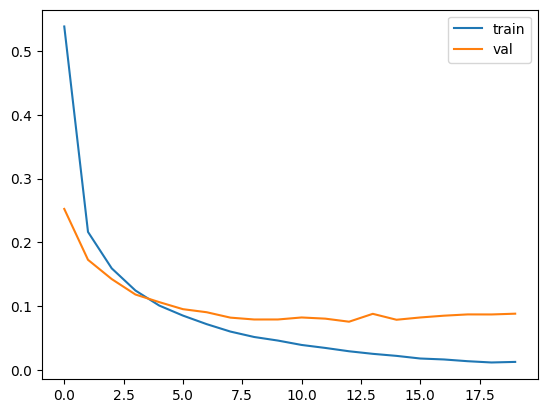

In [32]:
plt.plot(range(N_EPOCH), train_loss_list, label="train")
plt.plot(range(N_EPOCH), val_loss_list, label='val')
plt.legend()
plt.show()

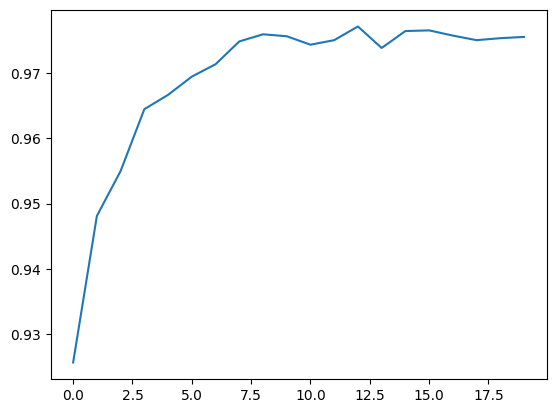

In [33]:
plt.plot(range(N_EPOCH), val_acc_list)
plt.show()

## 학습된 모델 저장 및 불러오기

In [34]:
save_path = os.path.join(MODEL_SAVE_PATH, "MNIST", "mnist_mlp.pth")
os.makedirs(os.path.join(MODEL_SAVE_PATH, "MNIST"), exist_ok=True)
save_path

'models/MNIST/mnist_mlp.pth'

In [35]:
torch.save(model, save_path)

In [36]:
# 불러오기
load_model = torch.load(save_path)

In [37]:
summary(load_model, (256, 784))

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 128]                100,480
├─Linear: 1-2                            [256, 64]                 8,256
├─Linear: 1-3                            [256, 10]                 650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 28.00
Input size (MB): 0.80
Forward/backward pass size (MB): 0.41
Params size (MB): 0.44
Estimated Total Size (MB): 1.65

## 모델 평가

In [38]:
load_model = load_model.to(device)
load_model.eval()

test_loss, test_acc = 0.0, 0.0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        # 추정
        pred_proba = load_model(X)
        # 평가 - loss, accuracy
        test_loss += loss_fn(pred_proba, y)
        pred_label = pred_proba.argmax(dim=-1)
        test_acc += torch.sum(pred_label == y).item()
    
    #평균
    test_loss /= len(test_loader)  # step수
    test_acc /= len(test_loader.dataset) # 데이터수
print(f"test loss: {test_loss}, test accuracy: {test_acc}")    

test loss: 0.08813629299402237, test accuracy: 0.9756


## 새로운 데이터 추론

In [39]:
from glob import glob

file_list = glob('test_img/num/*.png')
file_list

['test_img/num/1.png',
 'test_img/num/0.png',
 'test_img/num/6.png',
 'test_img/num/3.png',
 'test_img/num/8.png',
 'test_img/num/7.png',
 'test_img/num/4.png',
 'test_img/num/9.png',
 'test_img/num/5.png',
 'test_img/num/2.png']

In [41]:
# openCV 설치
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 31.0 MB/s eta 0:00:0000:0100:01


In [51]:
import cv2

file_cnt = len(file_list) #test할 이미지 개수.
input_tensor = torch.zeros((file_cnt, 28, 28)) #입력데이터(이미지들)을 저장할 tensor
# input_tensor.shape
for i in range(file_cnt):
    # 색상 반전시켜 읽기
    test_img = cv2.imread(file_list[i], cv2.IMREAD_GRAYSCALE)
    test_img = cv2.bitwise_not(test_img)
    test_img = cv2.resize(test_img, (28, 28))
    input_tensor[i] = transforms.ToTensor()(test_img) 
    # train set에 적용된 전처리를 적용. 개별 데이터별로 처리.

input_tensor.shape, input_tensor.min(), input_tensor.max()

(torch.Size([10, 28, 28]), tensor(0.), tensor(1.))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2824, 0.7490, 0.3765, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

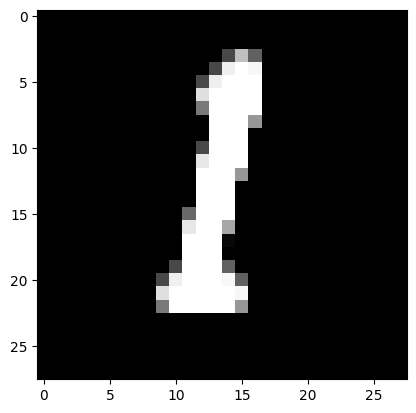

In [52]:
# 첫번째 이미지 확인
plt.imshow(input_tensor[0], cmap='gray')
input_tensor[0]

In [44]:
# 추론
load_model.to(device)
load_model.eval()
input_tensor = input_tensor.to(device)

pred_proba = load_model(input_tensor)
# 확률
pred_proba = nn.Softmax(dim=-1)(pred_proba)

In [45]:
print(pred_proba.shape)
pred_proba#.sum(dim=-1)

torch.Size([10, 10])


tensor([[2.2219e-05, 5.9651e-01, 1.4600e-04, 4.1305e-06, 8.9758e-08, 3.7684e-07,
         6.2572e-03, 4.3662e-08, 3.9706e-01, 3.2603e-09],
        [1.6260e-06, 8.7970e-06, 9.5752e-01, 3.3675e-04, 3.7518e-24, 2.7650e-11,
         4.2134e-02, 6.1504e-14, 1.2968e-07, 5.2324e-25],
        [8.5140e-08, 2.2068e-04, 2.0176e-04, 1.8506e-02, 6.3974e-15, 1.3175e-06,
         7.2522e-06, 9.1590e-10, 9.8106e-01, 3.8167e-12],
        [3.0437e-15, 1.2964e-09, 1.0233e-09, 1.0000e+00, 6.0240e-21, 9.0244e-07,
         3.4140e-13, 1.0039e-13, 4.1375e-08, 5.1195e-13],
        [1.5814e-16, 2.3901e-18, 2.3014e-12, 3.5595e-03, 3.7915e-23, 2.9722e-10,
         5.5057e-20, 7.0488e-19, 9.9644e-01, 5.8474e-12],
        [1.3989e-13, 1.3317e-05, 3.7128e-05, 9.9989e-01, 1.1845e-16, 3.3209e-13,
         1.2970e-16, 5.5920e-09, 6.0618e-05, 2.3682e-11],
        [1.7090e-13, 1.8819e-11, 1.7693e-12, 8.1399e-17, 1.0000e+00, 6.2179e-16,
         1.2620e-10, 7.2049e-09, 1.7406e-17, 1.6738e-09],
        [3.1291e-03, 8.9109

In [46]:
# 정답 확률
proba = pred_proba.max(dim=-1).values
label = pred_proba.argmax(dim=-1)

In [47]:
# 1번의 추정정답
proba[0], label[0]

(tensor(0.5965, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(1, device='cuda:0'))

In [48]:
proba = torch.round(proba, decimals=2)

In [49]:
proba[0].detach()

tensor(0.6000, device='cuda:0')

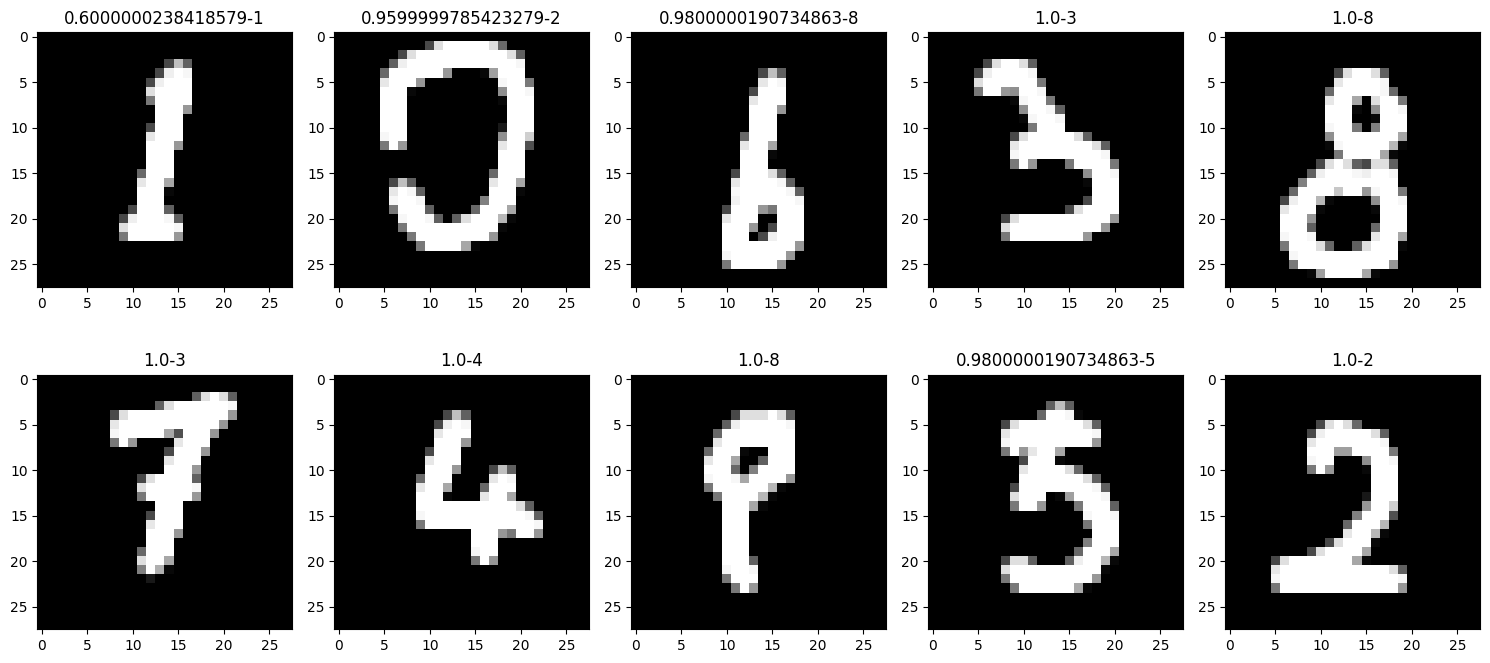

In [50]:
plt.figure(figsize=(15,7))
for i in range(file_cnt):
    plt.subplot(2, 5, i+1)
    plt.imshow(input_tensor[i].to('cpu'), cmap='gray')
    plt.title(f"{proba[i].detach()}-{label[i]}")
plt.tight_layout()
plt.show()